In [ ]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from joblib import dump

In [ ]:
speed_band = pd.DataFrame()

for day in range(30, 32):
    for hour in range(0, 24):
        filename = f'Traffic_202403{day:02d}{hour:02d}00.csv'
        try:
            df = pd.read_csv(filename)
            print(f'Reading file: {filename}')
            speed_band = pd.concat([speed_band, df], ignore_index=True)
        except FileNotFoundError as e:
            print(f'File not found: {filename}')
            pass

for day in range(1, 6):
    for hour in range(0, 24):
        filename = f'Traffic_202404{day:02d}{hour:02d}00.csv'
        try:
            df = pd.read_csv(filename)
            print(f'Reading file: {filename}')
            speed_band = pd.concat([speed_band, df], ignore_index=True)
        except FileNotFoundError as e:
            print(f'File not found: {filename}')
            pass
speed_band


File not found: Traffic_202403300000.csv
File not found: Traffic_202403300100.csv
File not found: Traffic_202403300200.csv
File not found: Traffic_202403300300.csv
File not found: Traffic_202403300400.csv
File not found: Traffic_202403300500.csv
File not found: Traffic_202403300600.csv
Reading file: Traffic_202403300700.csv
Reading file: Traffic_202403300800.csv
Reading file: Traffic_202403300900.csv
Reading file: Traffic_202403301000.csv
Reading file: Traffic_202403301100.csv
Reading file: Traffic_202403301200.csv
Reading file: Traffic_202403301300.csv
Reading file: Traffic_202403301400.csv
Reading file: Traffic_202403301500.csv
Reading file: Traffic_202403301600.csv
Reading file: Traffic_202403301700.csv
Reading file: Traffic_202403301800.csv
Reading file: Traffic_202403301900.csv
Reading file: Traffic_202403302000.csv
Reading file: Traffic_202403302100.csv
Reading file: Traffic_202403302200.csv
Reading file: Traffic_202403302300.csv
Reading file: Traffic_202403310000.csv
Reading fil

,LinkID,RoadName,RoadCategory,SpeedBand,MinimumSpeed,MaximumSpeed,StartLon,StartLat,EndLon,EndLat,datehour
0,103000000,KENT ROAD,E,3,20.0,29.0,103.852981,1.317014,103.852599,1.316684,2024-03-30 07
1,103000010,BUCKLEY ROAD,E,2,10.0,19.0,103.841023,1.316651,103.840226,1.316912,2024-03-30 07
2,103000011,BUCKLEY ROAD,E,3,20.0,29.0,103.840226,1.316912,103.841023,1.316651,2024-03-30 07
3,103000014,SHREWSBURY ROAD,E,4,30.0,39.0,103.847003,1.318673,103.847114,1.318021,2024-03-30 07
4,103000015,SHREWSBURY ROAD,E,2,10.0,19.0,103.847114,1.318021,103.847003,1.318673,2024-03-30 07
...,...,...,...,...,...,...,...,...,...,...,...
7434751,117000671,WOODLANDS SECTOR 2,C,3,20.0,29.0,103.809292,1.460595,103.809924,1.460907,2024-04-05 23
7434752,117000674,WOODLANDS AVENUE 10,C,5,40.0,49.0,103.810270,1.461077,103.810433,1.460750,2024-04-05 23
7434753,117000675,WOODLANDS AVENUE 10,C,3,20.0,29.0,103.810270,1.461077,103.810125,1.461361,2024-04-05 23
7434754,117000678,WOODLANDS AVENUE 10,C,6,50.0,59.0,103.810125,1.461361,103.810270,1.461077,2024-04-05 23


In [ ]:
# load
bus_info = pd.read_csv('bus_info.csv', header=0)
BusStopCode_X = bus_info['BusStopCode_X'].tolist()
passenger_volume = pd.read_csv('transport_node_bus_202403.csv', header=0)
passenger_volume.rename(columns={'DAY_TYPE': 'day_type', 'TIME_PER_HOUR': 'time_per_hour', 'PT_CODE': 'code_x'}, inplace=True)

rainfall_station = pd.read_csv('Rainfall_Station_Data.csv', header=0)
rainfall_station.rename(columns={'id': 'station_id'}, inplace=True)
rainfall_hourly_value = pd.read_csv('0330to0405_rainfall_hourly_value.csv', header=0)

speed_band['Speed'] = speed_band['SpeedBand'] * 10 - 5
speed_band['Latitude'] = (speed_band['StartLat'] + speed_band['EndLat']) / 2
speed_band['Longitude'] = (speed_band['StartLon'] + speed_band['EndLon']) / 2
speed_band_clean = speed_band.iloc[:, [0, 1, 2, 3, 10, 11, 12, 13]]
warnings.filterwarnings("ignore")

speed_band_clean['datehour'] = pd.to_datetime(speed_band_clean['datehour'], format='%Y-%m-%d %H', errors='coerce')
speed_band_clean_original = speed_band_clean.copy()
speed_band_clean_original.rename(columns={'Speed': 'Speed_current'}, inplace=True)
speed_band_clean['datehour'] = speed_band_clean['datehour'] - pd.Timedelta(hours=1)
# speed_band_clean.loc[speed_band_clean['datehour'].dt.hour == 23, 'datehour'] -= pd.Timedelta(days=1)
speed_band_clean.loc[(speed_band_clean['datehour'].dt.hour == 0) &
                     (speed_band_clean['datehour'].dt.day != (speed_band_clean['datehour'] - pd.Timedelta(days=1)).dt.day),
                     'datehour'] -= pd.Timedelta(days=1)

speed_band_clean['datehour'] = speed_band_clean['datehour'].dt.strftime("%Y-%m-%d %H")
speed_band_link = pd.read_csv('speed_band_link.csv', header=0)


In [ ]:
speed_band_clean

,LinkID,RoadName,RoadCategory,SpeedBand,datehour,Speed,Latitude,Longitude
0,103000000,KENT ROAD,E,3,2024-03-30 06,25,1.316849,103.852790
1,103000010,BUCKLEY ROAD,E,2,2024-03-30 06,15,1.316782,103.840624
2,103000011,BUCKLEY ROAD,E,3,2024-03-30 06,25,1.316782,103.840624
3,103000014,SHREWSBURY ROAD,E,4,2024-03-30 06,35,1.318347,103.847058
4,103000015,SHREWSBURY ROAD,E,2,2024-03-30 06,15,1.318347,103.847058
...,...,...,...,...,...,...,...,...
7434751,117000671,WOODLANDS SECTOR 2,C,3,2024-04-05 22,25,1.460751,103.809608
7434752,117000674,WOODLANDS AVENUE 10,C,5,2024-04-05 22,45,1.460914,103.810351
7434753,117000675,WOODLANDS AVENUE 10,C,3,2024-04-05 22,25,1.461219,103.810198
7434754,117000678,WOODLANDS AVENUE 10,C,6,2024-04-05 22,55,1.461219,103.810198


In [ ]:
speed_band_clean_original['datehour'] = speed_band_clean_original['datehour'].dt.strftime("%Y-%m-%d %H")
speed_band_clean_original

,LinkID,RoadName,RoadCategory,SpeedBand,datehour,Speed_current,Latitude,Longitude
0,103000000,KENT ROAD,E,3,2024-03-30 07,25,1.316849,103.852790
1,103000010,BUCKLEY ROAD,E,2,2024-03-30 07,15,1.316782,103.840624
2,103000011,BUCKLEY ROAD,E,3,2024-03-30 07,25,1.316782,103.840624
3,103000014,SHREWSBURY ROAD,E,4,2024-03-30 07,35,1.318347,103.847058
4,103000015,SHREWSBURY ROAD,E,2,2024-03-30 07,15,1.318347,103.847058
...,...,...,...,...,...,...,...,...
7434751,117000671,WOODLANDS SECTOR 2,C,3,2024-04-05 23,25,1.460751,103.809608
7434752,117000674,WOODLANDS AVENUE 10,C,5,2024-04-05 23,45,1.460914,103.810351
7434753,117000675,WOODLANDS AVENUE 10,C,3,2024-04-05 23,25,1.461219,103.810198
7434754,117000678,WOODLANDS AVENUE 10,C,6,2024-04-05 23,55,1.461219,103.810198


In [ ]:
# merge
# b
data = pd.DataFrame()
date_hour_range = pd.date_range(start='2024-03-30 00:00:00', end='2024-04-05 23:00:00', freq='H')
date_hour_column = date_hour_range[(date_hour_range.hour == 0) | ((date_hour_range.hour >= 6) & (date_hour_range.hour <= 23))]
date_hour_column = date_hour_column.repeat(146)  # 146 bus stop intervals
data['datehour'] = date_hour_column
data['datehour'] = data['datehour'].dt.strftime('%Y-%m-%d %H')
data['datehour'] = pd.to_datetime(data['datehour'])
holidays = ['2024-01-01']
data['day_type'] = data['datehour'].apply(lambda x: 'WEEKENDS/HOLIDAY' if (x.weekday() >= 5 or x.strftime('%Y-%m-%d') in holidays) else 'WEEKDAY')
# data['day_type'] = data['datehour'].dt.dayofweek.apply(lambda x: 'WEEKENDS/HOLIDAY' if x >= 5 else 'WEEKDAY')
data['time_per_hour'] = data['datehour'].dt.hour

# c
data['code_x'] = BusStopCode_X * 19 * 7
# data['code_y'] = BusStopCode_Y * 19 * 7
data['Latitude_X'] = data['code_x'].map(bus_info.set_index('BusStopCode_X')['Latitude_X'])
data['Longitude_X'] = data['code_x'].map(bus_info.set_index('BusStopCode_X')['Longitude_X'])
# data['Latitude_Y'] = data['code_y'].map(bus_info.set_index('BusStopCode_Y')['Latitude_Y'])
# data['Longitude_Y'] = data['code_y'].map(bus_info.set_index('BusStopCode_Y')['Longitude_Y'])
data['Distance'] = data['code_x'].map(bus_info.set_index('BusStopCode_X')['Interval_Distance'])
data['datehour'] = data['datehour'].dt.strftime('%Y-%m-%d %H')

# d
data = pd.merge(data, passenger_volume[['day_type', 'time_per_hour', 'code_x', 'TOTAL_VOLUME']], on=['day_type', 'time_per_hour', 'code_x'], how='left')

# e
data['Latitude_X'] = data['Latitude_X'].astype(float)
data['Longitude_X'] = data['Longitude_X'].astype(float)
distances_rain = cdist(np.array(bus_info[['Latitude_X', 'Longitude_X']]), np.array(rainfall_station[['latitude', 'longitude']]))
nearest_station_index_rain = np.argmin(distances_rain, axis=1)
nearest_station_ids = rainfall_station.iloc[nearest_station_index_rain]['station_id'].values
bus_info['station_id'] = nearest_station_ids
data['station_id'] = data['code_x'].map(bus_info.set_index('BusStopCode_X')['station_id'])
data = pd.merge(data, rainfall_hourly_value[['datehour', 'station_id', 'value']], on=['datehour', 'station_id'], how='left')

# f
distances_speed = cdist(np.array(bus_info[['Latitude_X', 'Longitude_X']]), np.array(speed_band_link[['Latitude', 'Longitude']]))
nearest_link_index = np.argmin(distances_speed, axis=1)
nearest_link_ids = speed_band_link.iloc[nearest_link_index]['LinkID'].values
bus_info['LinkID'] = nearest_link_ids
data['LinkID'] = data['code_x'].map(bus_info.set_index('BusStopCode_X')['LinkID'])
data = pd.merge(data, speed_band_clean[['datehour', 'LinkID', 'Speed']], on=['datehour', 'LinkID'], how='left')
data = pd.merge(data, speed_band_clean_original[['datehour', 'LinkID', 'Speed_current']], on=['datehour', 'LinkID'], how='left')

In [ ]:
data = data.dropna()
data['Interval'] = data['Distance'] / data['Speed'] * 60 # in min
data['Interval_current'] = data['Distance'] / data['Speed_current'] * 60
data

,datehour,day_type,time_per_hour,code_x,Latitude_X,Longitude_X,Distance,TOTAL_VOLUME,station_id,value,LinkID,Speed,Speed_current,Interval,Interval_current
292,2024-03-30 07,WEEKENDS/HOLIDAY,7,75009,1.354076,103.943391,0.6,15147,S84,0.0,103009182,15.0,15.0,2.400000,2.400000
293,2024-03-30 07,WEEKENDS/HOLIDAY,7,76059,1.352962,103.941652,0.5,667,S84,0.0,103069178,45.0,45.0,0.666667,0.666667
294,2024-03-30 07,WEEKENDS/HOLIDAY,7,76069,1.348753,103.942086,1.2,1910,S84,0.0,103016582,45.0,45.0,1.600000,1.600000
295,2024-03-30 07,WEEKENDS/HOLIDAY,7,96289,1.340055,103.948381,0.4,1391,S84,0.0,103105062,35.0,35.0,0.685714,0.685714
296,2024-03-30 07,WEEKENDS/HOLIDAY,7,96109,1.337371,103.950673,0.6,618,S84,0.0,103112762,25.0,25.0,1.440000,1.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19267,2024-04-05 22,WEEKDAY,22,85071,1.334077,103.949852,0.4,222,S84,0.0,103107610,35.0,35.0,0.685714,0.685714
19268,2024-04-05 22,WEEKDAY,22,96101,1.336385,103.951057,0.4,528,S84,0.0,103112766,35.0,25.0,0.685714,0.960000
19269,2024-04-05 22,WEEKDAY,22,96281,1.339714,103.948250,1.3,1287,S84,0.0,103095444,45.0,45.0,1.733333,1.733333
19270,2024-04-05 22,WEEKDAY,22,76061,1.348202,103.941898,0.5,3460,S84,0.0,103094638,45.0,35.0,0.666667,0.857143


In [ ]:
data.to_excel('merged_data.xlsx', index=False)

In [ ]:
data_encoded = pd.get_dummies(data, columns=['day_type', 'time_per_hour'])
features = ['Distance', 'TOTAL_VOLUME', 'value', 'Interval_current', 'day_type_WEEKDAY',
       'day_type_WEEKENDS/HOLIDAY', 'time_per_hour_7',
       'time_per_hour_8', 'time_per_hour_9', 'time_per_hour_10',
       'time_per_hour_11', 'time_per_hour_12', 'time_per_hour_13',
       'time_per_hour_14', 'time_per_hour_15', 'time_per_hour_16',
       'time_per_hour_17', 'time_per_hour_18', 'time_per_hour_19',
       'time_per_hour_22', 'time_per_hour_23']
# features_filtered = ['Distance', 'TOTAL_VOLUME', 'value', 'Interval_current']
X = data_encoded[features]
# X = data_encoded[features_filtered]
y = data_encoded['Interval']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# baseline
# tree_model = DecisionTreeRegressor(random_state=42)
# tree_model = DecisionTreeRegressor(max_depth=173, min_samples_split=9, min_samples_leaf=6, random_state=42)
tree_model = DecisionTreeRegressor(max_depth=45, min_samples_split=2, min_samples_leaf=1, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)

rf_model = RandomForestRegressor(random_state=42)
# rf_model = RandomForestRegressor(n_estimators=63, max_depth=23, min_samples_split=2, min_samples_leaf=2, random_state=42)
rf_model.fit(X_train, y_train)
# y_pred_rf_train = rf_model.predict(X_train)
# y_pred_rf_test = rf_model.predict(X_test)

# xgb_model = xgb.XGBRegressor(random_state=42)
# xgb_model = xgb.XGBRegressor(n_estimators = 140, max_depth = 5, learning_rate = 0.1, random_state=42)
# xgb_model.fit(X_train, y_train)
# y_pred_sgb_train = sgb_model.predict(X_train)
# y_pred_sgb_test = sgb_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_tree_train)
mse_test = mean_squared_error(y_test, y_pred_tree_test)
r2_train = r2_score(y_train, y_pred_tree_train)
r2_test = r2_score(y_test, y_pred_tree_test)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae_train = mean_absolute_error(y_train, y_pred_tree_train)
mae_test = mean_absolute_error(y_test, y_pred_tree_test)
mape_train = mape(y_train, y_pred_tree_train)
mape_test = mape(y_test, y_pred_tree_test)

print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f'Train MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Train MAPE: {mape_train}')
print(f'Test MAPE: {mape_test}')

Train R²: 0.9178
Test R²: 0.5642
Train MSE: 0.0327
Test MSE: 0.1584
Train MAE: 0.03707293758160447
Test MAE: 0.12048469738191447
Train MAPE: 4.110476157918517
Test MAPE: 14.046632447848694


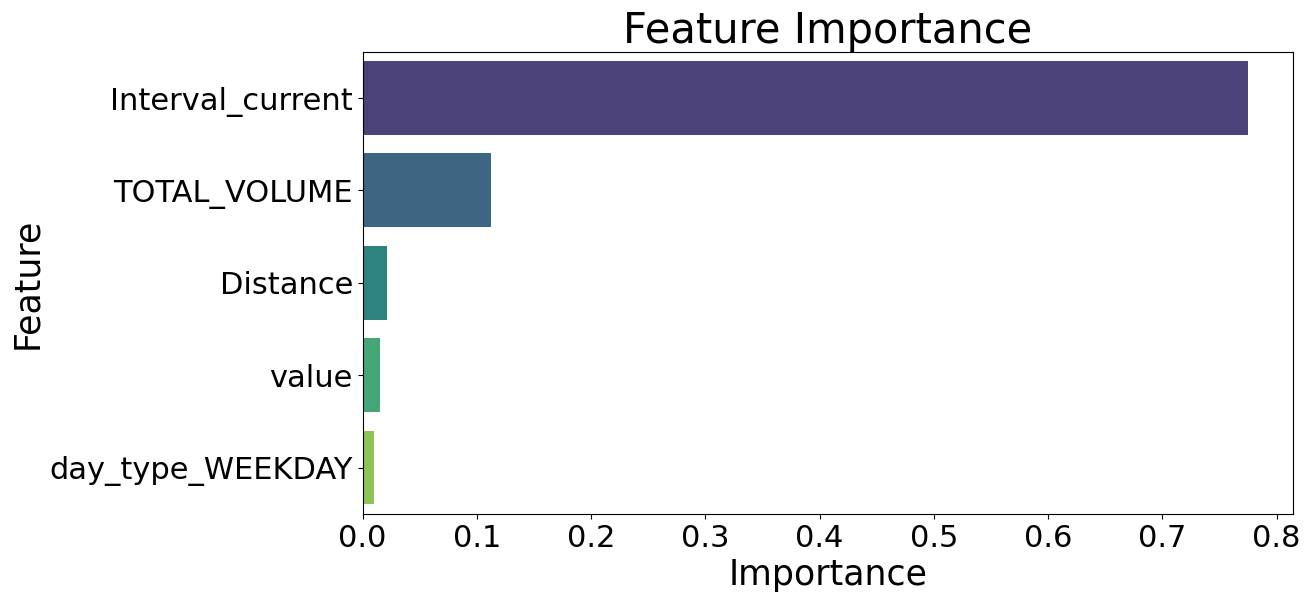

In [ ]:
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=30)  # Set fontsize here
plt.xlabel('Importance', fontsize=25)  # Set x-axis label fontsize
plt.ylabel('Feature', fontsize=25)  # Set y-axis label fontsize
plt.tick_params(axis='y', labelsize=22)
plt.tick_params(axis='x', labelsize=22)

plt.show()

In [ ]:
tree_param_grid = {
    'max_depth': randint(20, 200),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 5)
}

rf_param_grid = {
    'n_estimators': randint(20, 100),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 5)
}

xgb_param_grid = {
    'n_estimators': randint(120, 200),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.1)
}

tree_random_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), tree_param_grid, n_iter=100, cv=5, random_state=42)
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, n_iter=100, cv=5, random_state=42)
xgb_random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), xgb_param_grid, n_iter=100, cv=5, random_state=42)

tree_random_search.fit(X_train, y_train)
rf_random_search.fit(X_train, y_train)
xgb_random_search.fit(X_train, y_train)

print("Best parameters for Decision Tree:\n", tree_random_search.best_params_)
print("Best parameters for Random Forest:\n", rf_random_search.best_params_)
print("Best parameters for XGBoost:\n", xgb_random_search.best_params_)

Best parameters for Decision Tree:
 {'max_depth': 122, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters for Random Forest:
 {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 52}
Best parameters for XGBoost:
 {'learning_rate': 0.04829268747537899, 'max_depth': 3, 'n_estimators': 120}


In [ ]:
best_tree_params = tree_random_search.best_params_
tree_model = DecisionTreeRegressor(**best_tree_params, random_state=42)
tree_model.fit(X_train, y_train)

best_rf_params = rf_random_search.best_params_
rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train)

best_xgb_params = xgb_random_search.best_params_
xgb_model = xgb.XGBRegressor(**best_xgb_params, random_state=42)
xgb_model.fit(X_train, y_train)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)
mse_tree_train = mean_squared_error(y_train, y_pred_tree_train)
mse_tree_test = mean_squared_error(y_test, y_pred_tree_test)
r2_tree_train = r2_score(y_train, y_pred_tree_train)
r2_tree_test = r2_score(y_test, y_pred_tree_test)
mae_tree_train = mean_absolute_error(y_train, y_pred_tree_train)
mae_tree_test = mean_absolute_error(y_test, y_pred_tree_test)
mape_tree_train = mape(y_train, y_pred_tree_train)
mape_tree_test = mape(y_test, y_pred_tree_test)
print("Decision Tree Performance:")
print(f'Train MSE: {mse_tree_train}')
print(f'Test MSE: {mse_tree_test}')
print(f'Train MAE: {mae_tree_train}')
print(f'Test MAE: {mae_tree_test}')
print(f'Train MAPE: {mape_tree_train}')
print(f'Test MAPE: {mape_tree_test}')
print(f'Train R-squared: {r2_tree_train}')
print(f'Test R-squared: {r2_tree_test}')

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
r2_rf_train = r2_score(y_train, y_pred_rf_train)
r2_rf_test = r2_score(y_test, y_pred_rf_test)
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
mape_rf_train = mape(y_train, y_pred_rf_train)
mape_rf_test = mape(y_test, y_pred_rf_test)
print("\nRandom Forest Performance:")
print(f'Train MSE: {mse_rf_train}')
print(f'Test MSE: {mse_rf_test}')
print(f'Train MAE: {mae_rf_train}')
print(f'Test MAE: {mae_rf_test}')
print(f'Train MAPE: {mape_rf_train}')
print(f'Test MAPE: {mape_rf_test}')
print(f'Train R-squared: {r2_rf_train}')
print(f'Test R-squared: {r2_rf_test}')

y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)
mse_xgb_train = mean_squared_error(y_train, y_pred_xgb_train)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb_test)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)
mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
mape_xgb_train = mape(y_train, y_pred_xgb_train)
mape_xgb_test = mape(y_test, y_pred_xgb_test)
print("\nXGBoost Performance:")
print(f'Train MSE: {mse_xgb_train}')
print(f'Test MSE: {mse_xgb_test}')
print(f'Train MAE: {mae_xgb_train}')
print(f'Test MAE: {mae_xgb_test}')
print(f'Train MAPE: {mape_xgb_train}')
print(f'Test MAPE: {mape_xgb_test}')
print(f'Train R-squared: {r2_xgb_train}')
print(f'Test R-squared: {r2_xgb_test}')

Decision Tree Performance:
Train MSE: 0.07785102558345494
Test MSE: 0.12153046385114755
Train MAE: 0.09370314266821027
Test MAE: 0.12423986008951995
Train MAPE: 11.112263973383314
Test MAPE: 14.642987157715295
Train R-squared: 0.804496362316161
Test R-squared: 0.6656527824169806

Random Forest Performance:
Train MSE: 0.08211273515955238
Test MSE: 0.10459746909278887
Train MAE: 0.10116642740765913
Test MAE: 0.11120472948663196
Train MAPE: 12.139812248649823
Test MAPE: 13.058907060441452
Train R-squared: 0.7937941304748354
Test R-squared: 0.7122378073020939

XGBoost Performance:
Train MSE: 0.09667335227238846
Test MSE: 0.10588634264469923
Train MAE: 0.11044315853043654
Test MAE: 0.11104831425715675
Train MAPE: 13.804229686830297
Test MAPE: 13.687074272131161
Train R-squared: 0.7572287340507452
Test R-squared: 0.7086919368080473


In [ ]:
dump(rf_model, 'random_forest_model.joblib')

['random_forest_model.joblib']